In [9]:
# source group/bagel/Task_1.B/brainseg_env/bin/activate
# python group/bagel/Task_1.B/main.py

import os
# from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model
import tensorflow as tf

from data_handling import *
from model import *
from eval import *

2023-12-13 01:01:27.998511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-13 01:01:27.998543: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [6]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


# Set GPU device

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate memory on the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


2023-12-11 17:55:59.013494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6465 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:21:00.0, compute capability: 7.5


# Set Parameters

In [2]:
os.getcwd()

'/group/bagel/Task_1.B'

In [23]:
data_path = '/data/segmentation/train'
figs_path = '/group/bagel/Task_1.B/figures'

In [24]:
segment_classes = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',  # or NON-ENHANCING tumor CORE
    2: 'EDEMA',
    4: 'ENHANCING'  # original 4 -> converted into 3 later
}

# after compression
IMG_SIZE=128

# Define selected slices range
VOLUME_START_AT = 60 
VOLUME_SLICES = 75 
N_CHANNELS = 2 # Number of channels (==2: "T1CE + FLAIR") !! Change vals in __data_generation when modify this param!

# Load a sample

In [5]:
patient = {'id' : '00021', 'data' : []}

sample_path = os.path.join(data_path, patient['id'])

sample = DataLoader(sample_path)
patient['data'] = sample.explore_sample(patient['id'])

# Plot sample

In [6]:
plot = Plotting(sample_path)

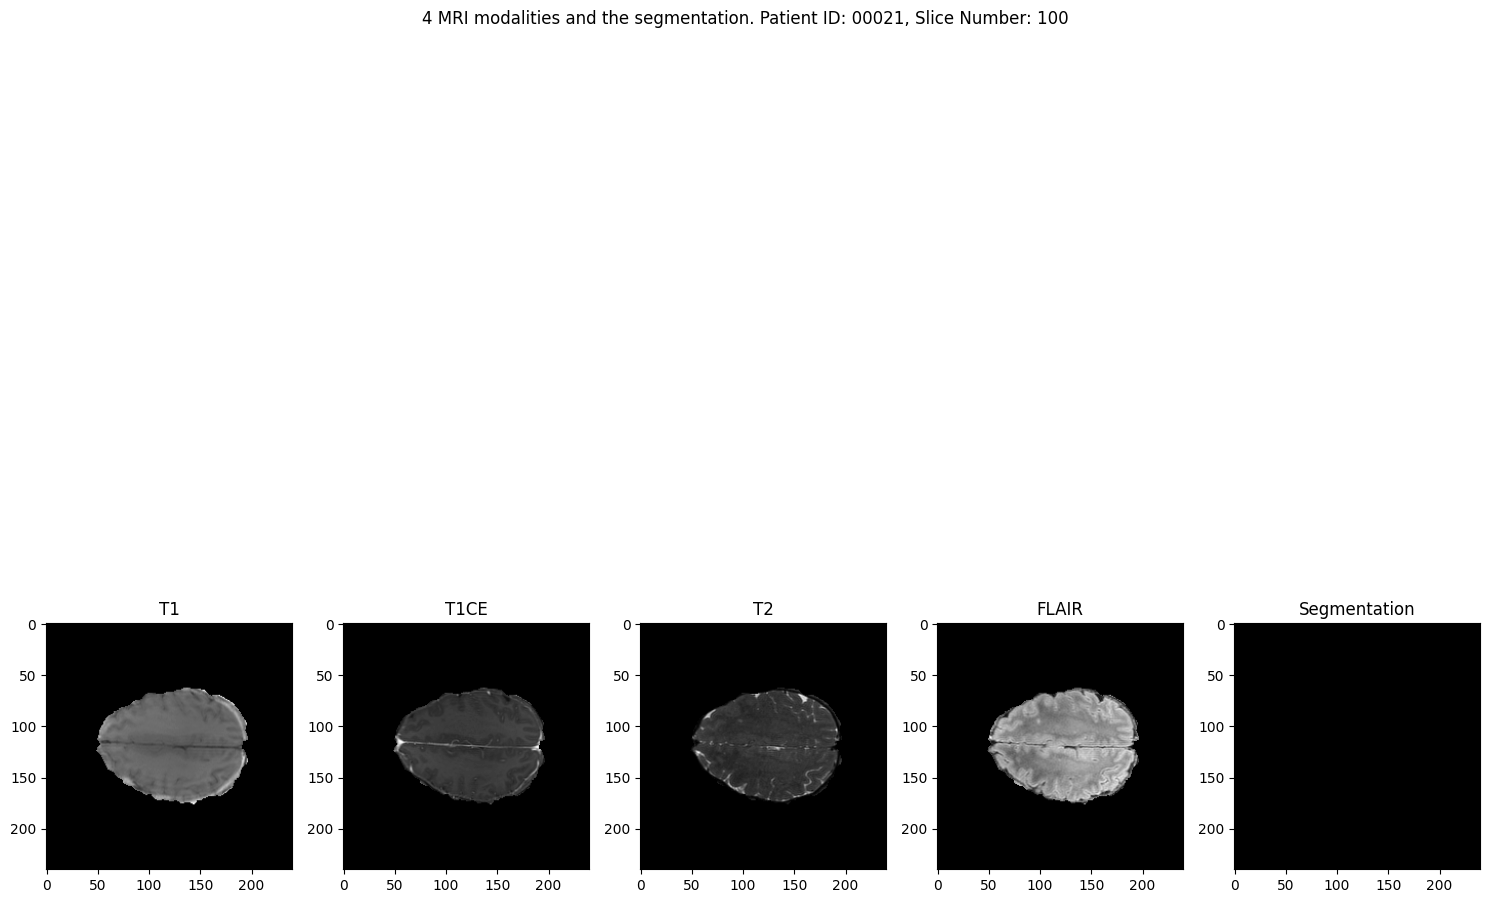

Figure saved at: /group/bagel/Task_1.B/figures/id00021_slice100.png


<Figure size 640x480 with 0 Axes>

In [7]:
from data_handling import *
plot.plot_one_slice_all_mods(patient['data'], patient['id'], slice_nb=100, show_plot=True, save_path=figs_path)

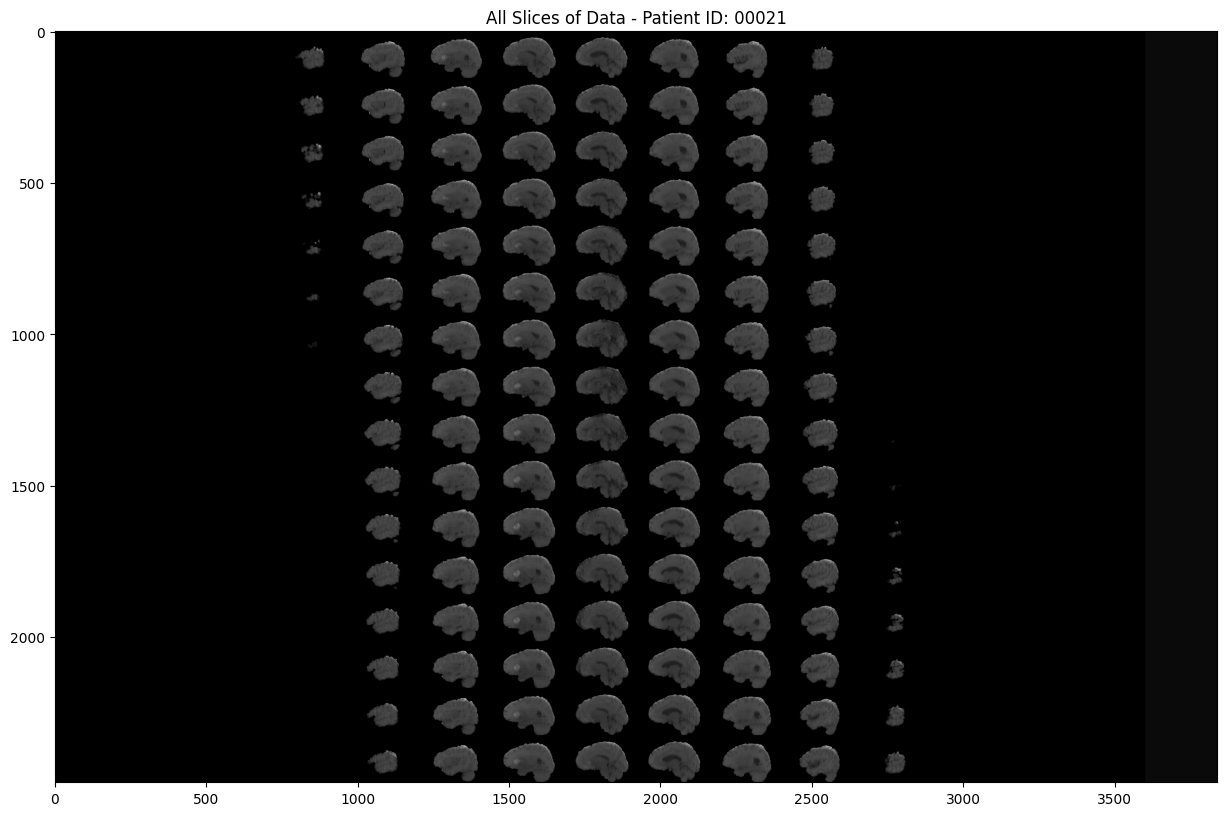

Data slices figure saved at: /group/bagel/Task_1.B/figures/id00021_data_slices.png


<Figure size 640x480 with 0 Axes>

In [8]:
plot.plot_one_mod_all_slices(patient['data'][0], patient['id'], show_plot=True, save_path=figs_path)

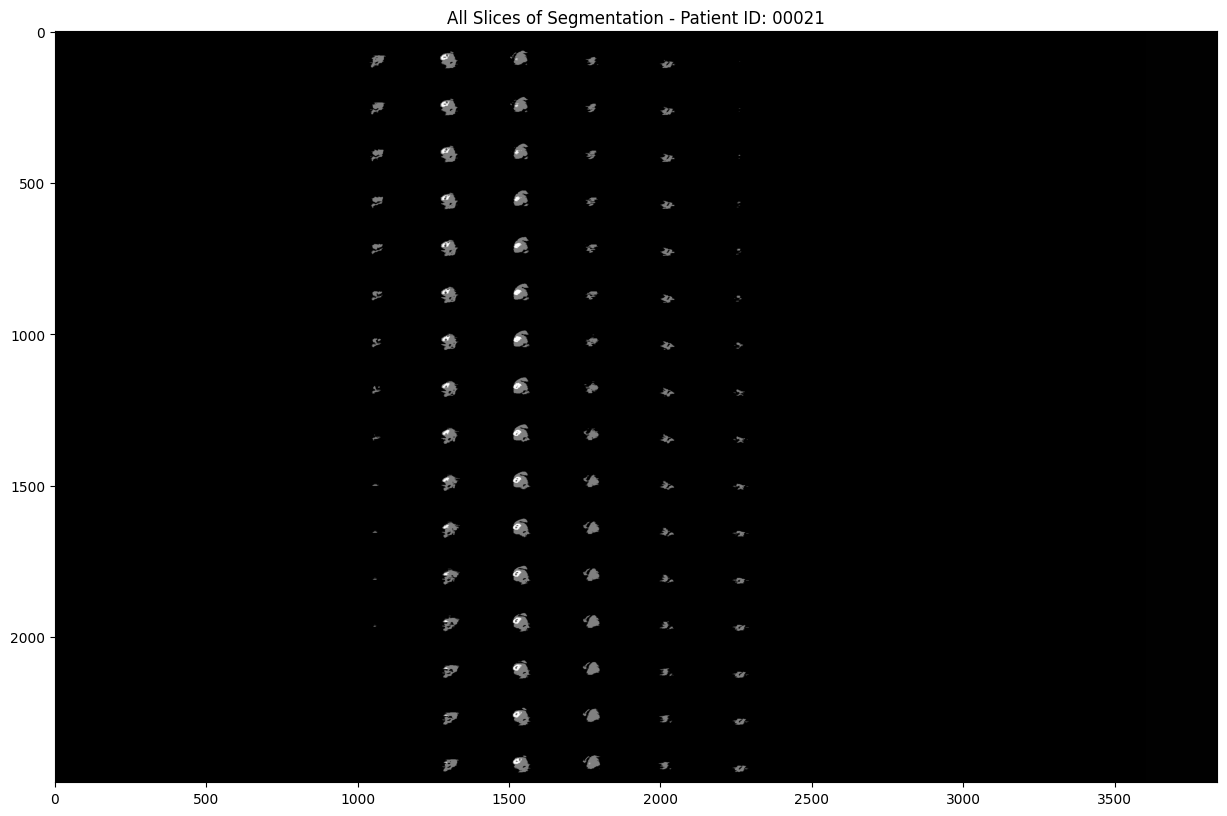

Segmentation slices figure saved at: /group/bagel/Task_1.B/figures/id00021_seg_slices.png


<Figure size 640x480 with 0 Axes>

In [9]:
plot.plot_seg_one_slice(patient['data'][4], patient['id'], show_plot=True, save_path=figs_path)

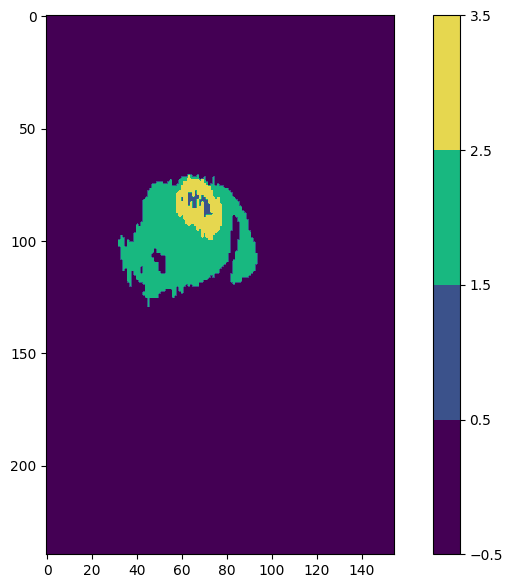

Segmentation plot saved at: /group/bagel/Task_1.B/figures/id00021_seg_plot.png


<Figure size 640x480 with 0 Axes>

In [10]:
plot.plot_segmentation(patient['data'][4][100, :, :], patient['id'], show_plot=True, save_path=figs_path)

# Load and generate the data

In [11]:
data = DataLoader(data_path)

In [26]:
# Do not reexecute-- This fucntion might take a lot of time to run. 
# TODO: Plot a histogram
# data.explore_seg(segment_classes)

Number of segmentation samples: 1000


Loading & analyzing unique segmentations: 100%|██████████| 1000/1000 [07:26<00:00,  2.24sample/s]


Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 4.]
Distribution of the 4 classes in sample 0:
- Class 0.0: NOT tumor, Pixels: 8870695
- Class 1.0: NECROTIC/CORE, Pixels: 11738
- Class 2.0: EDEMA, Pixels: 12836
- Class 4.0: ENHANCING, Pixels: 32731


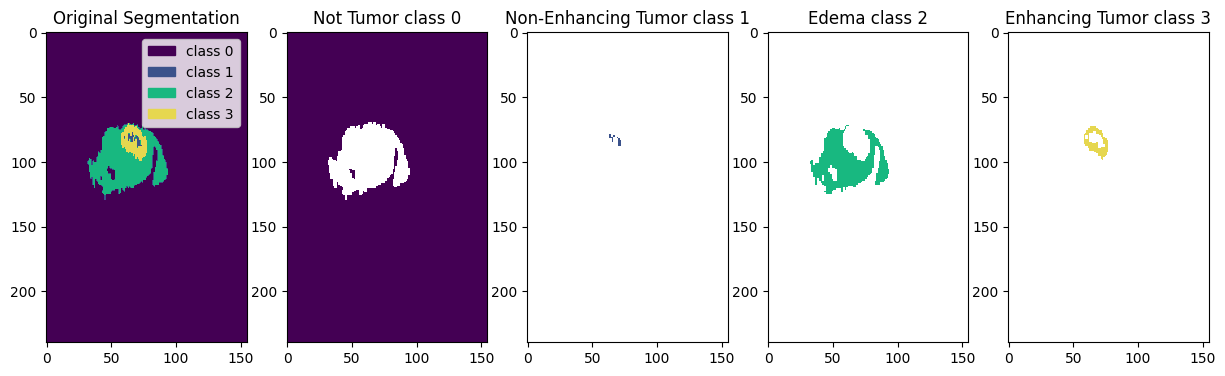

Segmented classes plot saved at: /group/bagel/Task_1.B/figures/id00021classes_seg.png


<Figure size 640x480 with 0 Axes>

In [27]:
plot.plot_seg(patient['data'][4][100, :, :], patient['id'], save_path=figs_path)

In [28]:
samples_train, samples_val, samples_test = data.split_datset(val_size=0.2, test_size=0.15)


Number of all samples: 1000
Trainset size (96%): 680 samples
Validation size (20%): 200 samples
Testset size (15%): 120 samples


# Build the model

In [29]:
training_generator = DataGenerator(data_path, samples_train, (IMG_SIZE, IMG_SIZE),
                                   VOLUME_START_AT, VOLUME_SLICES, N_CHANNELS, batch_size = 1)

In [30]:
valid_generator = DataGenerator(data_path, samples_val, (IMG_SIZE, IMG_SIZE), 
                                VOLUME_START_AT, VOLUME_SLICES, N_CHANNELS, batch_size = 1)

In [31]:
test_generator = DataGenerator(data_path, samples_test, (IMG_SIZE, IMG_SIZE), 
                                VOLUME_START_AT, VOLUME_SLICES, N_CHANNELS, batch_size = 1)

In [32]:
## Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

In [33]:
# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)

In [34]:
model.compile(loss="categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  metrics = ['accuracy',
                             tf.keras.metrics.MeanIoU(num_classes=4), 
                             dice_coef, 
                             precision, 
                             sensitivity, 
                             specificity])

In [35]:
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                               patience=2, min_lr=0.000001, verbose=1),

             keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                                             verbose=1, save_best_only=True, save_weights_only = True),

             CSVLogger('training.log', separator=',', append=False)]

## Start training

In [1]:
# K.clear_session()

# model.fit(training_generator,
#           epochs=30,
#           steps_per_epoch=len(samples_train),
#           callbacks=callbacks,
#           validation_data=valid_generator)

# model.save("model_x1_1.h5")

NameError: name 'model' is not defined

## Or load a trained model

In [ ]:
# Compile a model and load our saved weights
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

best_saved_model.compile(loss="categorical_crossentropy",
                         optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
                         metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4),
                                    dice_coef, precision, sensitivity, specificity])

# best_saved_model.load_weights('model_.26-0.025329.m5')

In [ ]:
# ############ load trained model ################
# model = keras.models.load_model('../input/modelperclasseval/model_per_class.h5',
#                                 custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
#                                                 "dice_coef": dice_coef,
#                                                 "precision": precision,
#                                                 "sensitivity":sensitivity,
#                                                 "specificity":specificity,
#                                                 "dice_coef_necrotic": dice_coef_necrotic,
#                                                 "dice_coef_edema": dice_coef_edema,
#                                                 "dice_coef_enhancing": dice_coef_enhancing
#                                                 }, compile=False)

# Anlyzing

In [ ]:
plot_acc_loss_iou(show_plot=True, save_path=figs_path)

In [ ]:
plot_dice(show_plot=True, save_path=figs_path)

# Prediction examples (on testset)
Plot Random predictions & Compare with Original (Ground truth) 

In [ ]:
show_predicted_segmentations(samples_test, 60, cmap, norm)

In [ ]:
show_predicted_segmentations(samples_test, 50, cmap, norm)

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

In [ ]:
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])


# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=60, cmap=cmap, norm=norm)

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=50, cmap=cmap, norm=norm)

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=70, cmap=cmap, norm=norm)

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=70, cmap=cmap, norm=norm)


In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_274", slice_to_plot=70, cmap=cmap, norm=norm)

# Evaluate

In [ ]:
# Evaluate the model on the test data

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")